In [2]:
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import scipy
%load_ext autoreload
%autoreload
import ipdb
import glob, os
import sys
from scipy.special import logit
sys.path.append('..')

from familiarity.commons import get_layers_of_interest
from familiarity.resampled_familiarization import get_results 
from familiarity.config import DATA_DIR

data_dir=os.path.join(DATA_DIR, 'fine_tuning')
save_dir='../figures'

def plot_separate(results, y='dprime', base_fn=None, hue='training_set', condition=1, estimator=np.mean):
    kwargs={'palette':'bright', 'height':4}
    g = sns.catplot('layer', y, hue=hue, col='familiar', split=True, kind='point', ci=95,estimator=estimator,
              data=results[np.logical_and(condition,np.ones((len(results),)))], ylabel=r"verification $d$'", **kwargs)
    g.set_xticklabels(rotation=45)
    if base_fn is not None:
        plt.savefig(f'figures/verification/{base_fn}.png', bbox_inches='tight')
    plt.show()
    
def plot_together(results, base_fn=None, 
                  familiar=None, 
                  y='dprime',
                  hue='training_set', 
                  condition=1,
                  title=None,
                  y_max=4.7,
                  estimator=np.mean,
                  ci=95,
                  log_y=False,
                  show=True,
                  save_dir='../figures',
                 ):
    fig, ax = plt.subplots()
    fam_tag = '_familiar' if familiar is 'familiar' else '_unfamiliar' if familiar is 'unfamiliar' else ''
    if familiar is not 'unfamiliar':
        g = sns.pointplot('layer', y, hue=hue, ax=ax, palette='bright', ci=ci, estimator=estimator,
                      data=results[np.logical_and(condition,results.familiar==True)])
    if familiar is not 'familiar':
        g = sns.pointplot('layer', y, hue=hue, ax=ax, linestyles='--', markers='v', palette='colorblind',ci=ci,estimator=estimator,
                      data=results[np.logical_and(condition,results.familiar==False)])
    handles, labels = ax.get_legend_handles_labels() 
    if familiar is None:
        nn = len(np.unique(getattr(results, hue)))
        labels = [label + '-familiar' if ii<nn else label+'-unfamiliar' for ii, label in enumerate(labels)]
        leg_title = 'training set, familiarized'
    else:
        leg_title = 'training set'
    l = plt.legend(handles, labels, bbox_to_anchor=(.1, 1), title=leg_title,loc=2, borderaxespad=0.)
    if log_y:
        g.set_yscale('log')
    plt.xticks(rotation=45)
    plt.ylim(0.001, y_max)
    if title is not None:
        plt.title(title)
    if base_fn is not None:
        fig.savefig(f'{save_dir}/verification/{base_fn}{fam_tag}.png', bbox_inches='tight')
    if show:
        plt.show()
    return

# Split-validated results for VGGFace2 across many sets of fine-tuning conditions

control the number of identities in the line below (10 or 100)

In [3]:
n_ids = 10

In [4]:
def get_all_results_new_bootstrapped(net, dataset, training_sets, layers, first_finetuned_layers, 
                    n_trains=[50],
                    epochs_per_model=[50],
                    results_type='verification-dprime', 
                    familiar_epoch=-1,
                     do_logit=False,
                    **kwargs):
    results = dict(n_train=[], layer=[], training_set=[], familiar=[],start_ft_at=[],boot_perc=[])
    if 'dprime' in results_type:
        results['dprime']= []
    elif 'AUC' in results_type:
        results['AUC'] = []
    elif 'rates' in results_type:
        results['fpr'], results['tpr'] = [], []
    for nt_i, n_train in enumerate(n_trains):
        epochs = epochs_per_model[nt_i]
        for training_set, net_name in training_sets.items():
            for first_ft_layer in first_finetuned_layers:
                ft_ind = layers.index(first_ft_layer)
                finetuned_layers = layers[ft_ind::]
                for layer in layers:
                    for epoch in [0,familiar_epoch]:
                        use_epoch = epoch if layer in finetuned_layers else 0
                        try:
                            res = get_results(results_type, net_name, dataset, use_epoch, layer,
                                              first_finetuned_layer=first_ft_layer,
                                              n_train=n_train,
                                              n_epochs=epochs,
                                              **kwargs)
                            for ii, result in enumerate(sorted(res)):
                                results['n_train'].append(n_train)
                                results['layer'].append(layer)
                                results['familiar'].append(epoch == familiar_epoch)
                                results['training_set'].append(training_set)
                                results['start_ft_at'].append(first_ft_layer)
                                results['boot_perc'].append(100*ii/len(res))
                                if do_logit:
                                    result = logit(result)
                                if 'dprime' in results_type:
                                    results['dprime'].append(result)
                                elif 'AUC' in results_type:
                                    results['AUC'].append(result)
                                elif 'rates' in results_type:
                                    results['fpr'].append(result[0])
                                    results['tpr'].append(result[1])
                        except Exception as e: 
                                print(e)
    if 'dprime' in results_type:
        results['dprime'] = np.array(results['dprime'])
        results['dprime'][results['dprime'] == np.inf] = 15
        results['dprime'][results['dprime'] == np.nan] = 0
    results = pd.DataFrame(results)
    return results


net='vgg16'
n_trains = [1,10,50,100,400]
epochs_per_model=[1000,1000,1000,1000,1000,1000]
splitvals=20
metric='dprime'
dataset=f'vggface2-test_subset-{n_ids}-400-10-{int(1000/n_ids)}'

first_finetuned_layers=['conv1', 'conv2', 'conv3', 'conv4', 'conv5','fc6','fc7','fc8']
_, layers = get_layers_of_interest(net)

training_sets = dict(faces=f'{net}_train-vggface2-match-imagenet-subset',
                    objects=f'{net}_train-imagenet-subset', 
                    nothing=f'{net}_random')
all_results = get_all_results_new_bootstrapped(net, dataset, training_sets, layers, first_finetuned_layers,
                                            n_trains=n_trains,
                                            results_type=f'verification-{metric}',
                                            epochs_per_model=epochs_per_model,
                                            data_dir=data_dir,
                                            splitvals=splitvals)


## compiled results

/home/nblauch/anaconda3/envs/mne/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


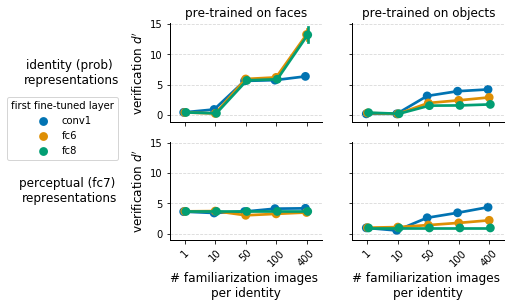

In [8]:
palette ='colorblind'

results = all_results
fig, axs = plt.subplots(2,2,figsize=(6,4), sharey=True, sharex=True)
g = sns.pointplot(ax=axs[0,0], data=results[
    np.logical_and.reduce((results.familiar==True,
    results.training_set=='faces', results.layer=='prob',
    np.logical_or.reduce((results.start_ft_at=='conv1', results.start_ft_at=='fc6', results.start_ft_at=='fc8'))
    ))], 
    x='n_train', y=metric, hue='start_ft_at',
    ci=95, dodge=True, palette=palette)
g.set_title(f'pre-trained on faces')
g.set_xlabel('')
g.set_ylabel("verification $d'$")
if dataset != 'vggface2-test_subset-100-400-10-10':
    g.annotate('identity (prob) \nrepresentations', xy=(0, 0.5), xytext=(-g.yaxis.labelpad - 8, 0),
                                    xycoords=g.yaxis.label, textcoords='offset points',
                                    size='large', ha='right', va='center',
                                     multialignment='center')
g.set_xticklabels(g.get_xticklabels(), rotation=45)
g.legend().remove()

g = sns.pointplot(ax=axs[0,1], data=results[
    np.logical_and.reduce((results.familiar==True,
    results.training_set=='objects', results.layer=='prob',
    np.logical_or.reduce((results.start_ft_at=='conv1', results.start_ft_at=='fc6', results.start_ft_at=='fc8'))
    ))], 
    x='n_train', y=metric, hue='start_ft_at',
    ci=95, dodge=True, palette=palette)
g.set_title(f'pre-trained on objects')
g.set_xlabel('')
g.set_ylabel('')
g.legend().remove()
g.set_xticklabels(g.get_xticklabels(), rotation=45)

g = sns.pointplot(ax=axs[1,0], data=results[
    np.logical_and.reduce((results.familiar==True,
    results.training_set=='faces', results.layer=='fc7',
    np.logical_or.reduce((results.start_ft_at=='conv1', results.start_ft_at=='fc6', results.start_ft_at=='fc8'))
    ))], 
    x='n_train', y=metric, hue='start_ft_at',
    ci=95, dodge=True, palette=palette)
g.set_title('')
g.set_ylabel("verification $d'$")
g.set_xlabel('# familiarization images \nper identity')
g.legend(title='first fine-tuned layer', loc='upper left', bbox_to_anchor=(-1.1, 1.5))
if dataset == 'vggface2-test_subset-100-400-10-10':
    g.legend().remove()
g.set_xticklabels(g.get_xticklabels(), rotation=45)
if dataset != 'vggface2-test_subset-100-400-10-10':
    g.annotate('perceptual (fc7) \nrepresentations', xy=(0, 0.5), xytext=(-g.yaxis.labelpad - 8, 0),
                                xycoords=g.yaxis.label, textcoords='offset points',
                                size='large', ha='right', va='center',
                                 multialignment='center')
 
g = sns.pointplot(ax=axs[1,1], data=results[
    np.logical_and.reduce((results.familiar==True,
    results.training_set=='objects', results.layer=='fc7', 
    np.logical_or.reduce((results.start_ft_at=='conv1', results.start_ft_at=='fc6', results.start_ft_at=='fc8'))
    ))], 
    x='n_train', y=metric, hue='start_ft_at',
    ci=95, dodge=True, palette=palette)
g.set_title('')
g.set_xlabel('# familiarization images \nper identity')
g.set_ylabel('')
g.set_xticklabels(g.get_xticklabels(), rotation=45)
g.legend().remove()
    
# plt.tight_layout()
fig.savefig(f'{save_dir}/verification/{dataset}_splitvals-{splitvals}_by-n-train.png', bbox_inches='tight')

## example full results for a given layer and number of training images per identity

/home/nblauch/anaconda3/envs/mne/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


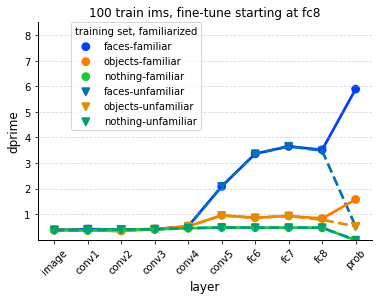

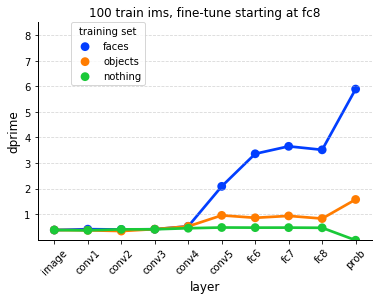

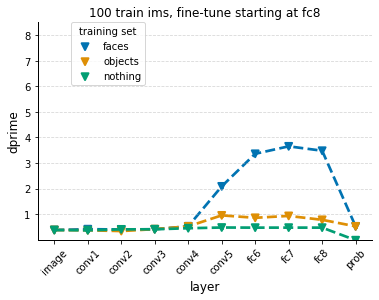

In [6]:
ft_layer = 'fc8'
n_train=100

results = all_results[all_results.n_train==n_train]
for familiar in [None, 'familiar', 'unfamiliar']:
                plot_together(results, 
                              hue='training_set', 
                              condition=results.start_ft_at==ft_layer, 
                              title=f'{n_train} train ims, fine-tune starting at {ft_layer}',
                              base_fn=f'{dataset}_ntrain-{n_train}_splitvals-{splitvals}_start-ft-at-{ft_layer}',
                              y_max=8.5,
                              familiar=familiar,
                              show=familiar is None,
                              log_y=False)

## full results over all layers and number of training images per identity

/home/nblauch/anaconda3/envs/mne/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


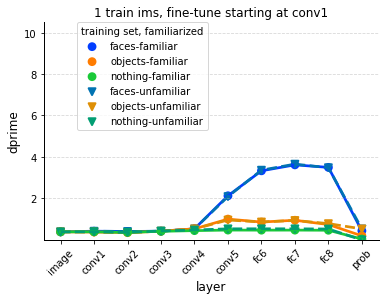

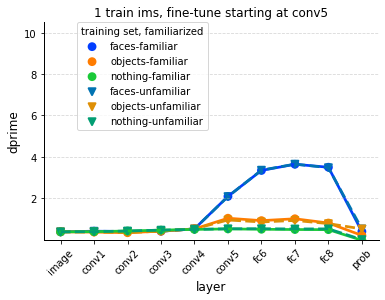

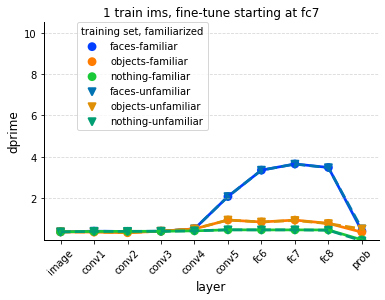

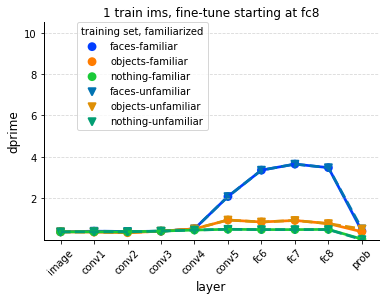

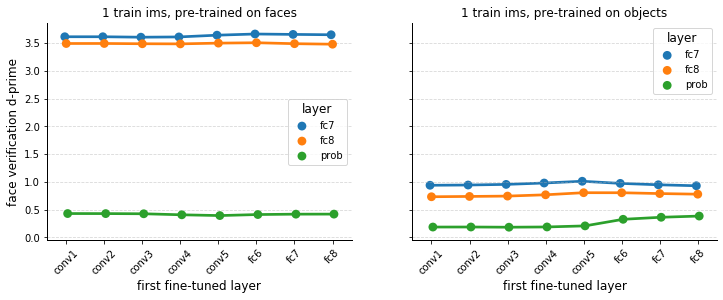

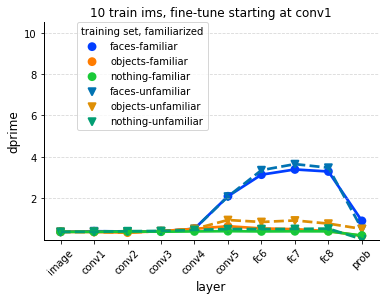

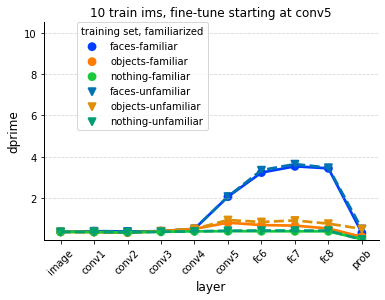

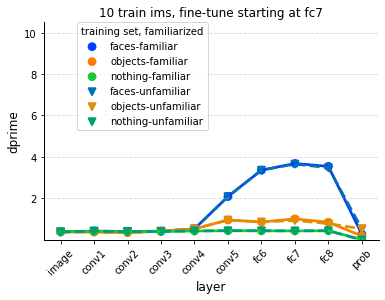

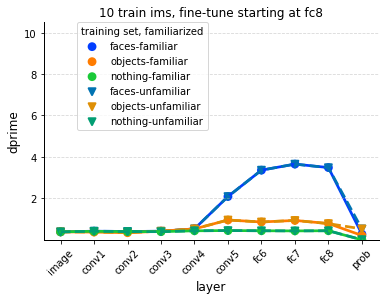

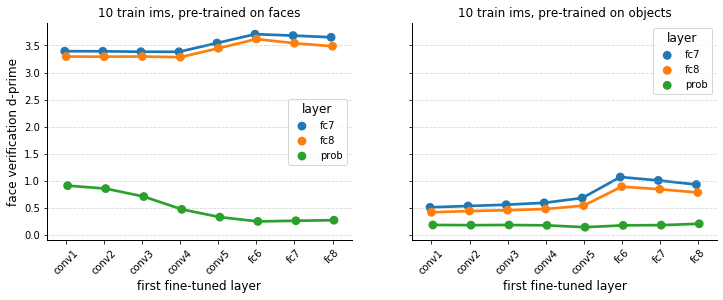

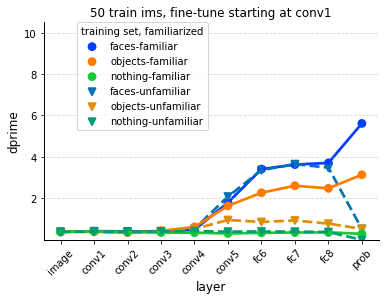

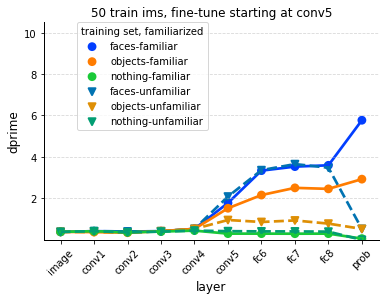

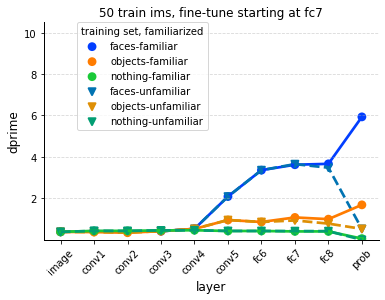

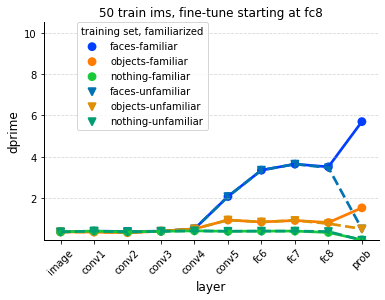

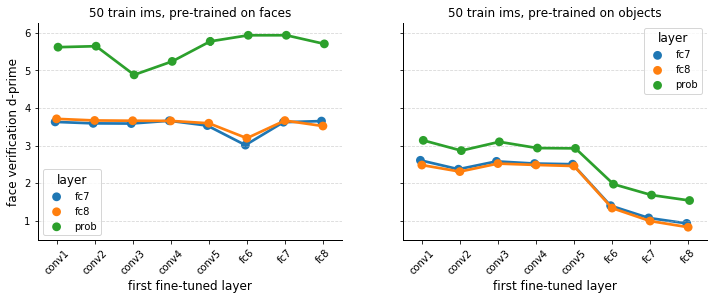

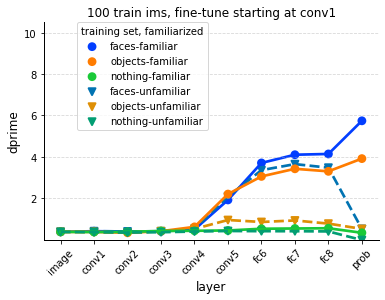

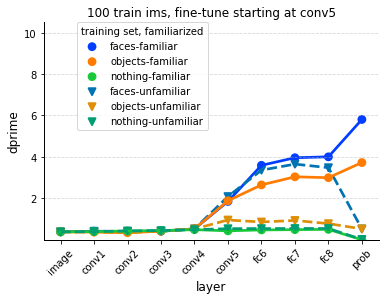

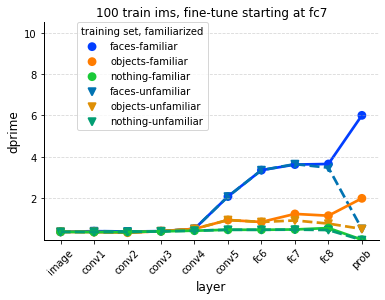

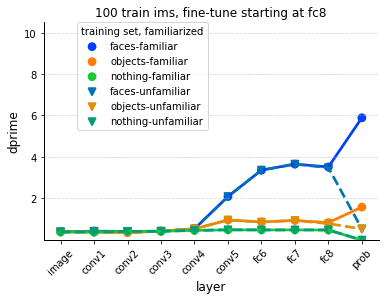

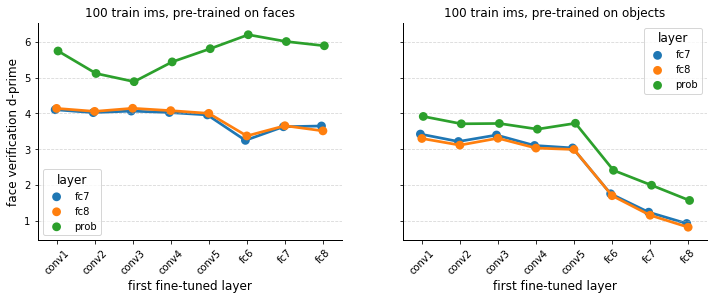

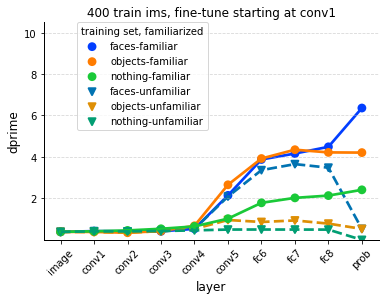

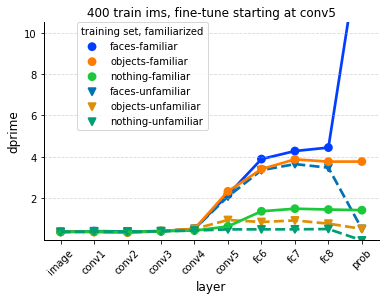

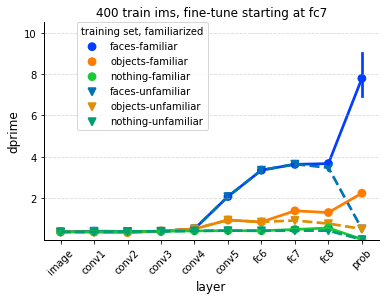

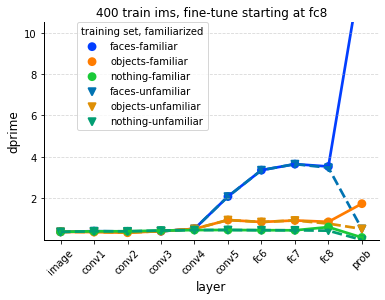

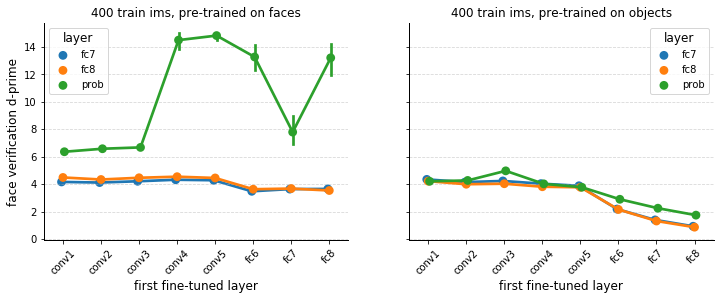

In [7]:
for n_train in n_trains:
    results = all_results[all_results.n_train==n_train]
    for ft_layer in ['conv1', 'conv5', 'fc7', 'fc8']:
        try:
            for familiar in [None]: # use 'familiar' or 'unfamiliar' to show only one condition per plot
                plot_together(results, 
                              hue='training_set', 
                              condition=results.start_ft_at==ft_layer, 
                              title=f'{n_train} train ims, fine-tune starting at {ft_layer}',
                              base_fn=f'{dataset}_ntrain-{n_train}_splitvals-{splitvals}_start-ft-at-{ft_layer}',
                              y_max=10.5,
                              familiar=familiar,
                              show=familiar is None,
                              log_y=False)
        except:
            pass
    try:
        fig, axs = plt.subplots(1,2, figsize=(12,4), sharey=True)
        g = sns.pointplot(ax=axs[0],  data=results[np.logical_and(
            np.logical_and(results.familiar==True,
            results.training_set=='faces'),
            np.logical_or(results.layer=='fc7',
            np.logical_or(results.layer == 'fc8', results.layer=='prob'))
            )], 
            x='start_ft_at', y=metric, hue='layer',
            ci=95, dodge=True)
        g.set_title(f'{n_train} train ims, pre-trained on faces')
        g.set_xlabel('first fine-tuned layer')
        g.set_ylabel('face verification d-prime')
        g.set_xticklabels(g.get_xticklabels(), rotation=45)
    #     g.set_yscale('log')
        # plt.show()
        # for pair in [['fc6', 'fc8'], ['fc7', 'fc8']]:
        #     t,p = scipy.stats.ttest_rel(
        #         results.dprime[np.logical_and.reduce(
        #         (results.layer=='prob', results.training_set=='faces', results.start_ft_at==pair[0], results.familiar==True))],
        #         results.dprime[np.logical_and.reduce(
        #         (results.layer=='prob', results.training_set=='faces', results.start_ft_at==pair[1], results.familiar==True))]                      
        #                                )
        #     print(f'difference between familiarized output-layer d-prime with pre-training starting at {pair[0]} vs. {pair[1]}\nt={t:03f},p={p:03f}')

        g = sns.pointplot(ax=axs[1], data=results[np.logical_and(
            np.logical_and(results.familiar==True,
            results.training_set=='objects'),
            np.logical_or(results.layer=='fc7',
            np.logical_or(results.layer == 'fc8', results.layer=='prob'))
            )], 
            x='start_ft_at', y=metric, hue='layer',
            ci=95, dodge=True)
        g.set_title(f'{n_train} train ims, pre-trained on objects')
        g.set_xlabel('first fine-tuned layer')
        g.set_ylabel('')
        g.set_xticklabels(g.get_xticklabels(), rotation=45)
        fig.savefig(f'{save_dir}/verification/{dataset}_ntrain-{n_train}_splitvals-{splitvals}_by-ft-layer.png', bbox_inches='tight')

        plt.show()
    except:
        pass
    